# Introduction
For the simple demo of RAG pipeline, lets build a simple chatbot that can answer questions from PDF. By the end of this section, you will have a good overview of how to build a simple RAG chatbot using Langchain and Python. For this exercise, We will be using OpenAI models for this so please keep the OPENAI_API_KEY handy.




## Ingestion:

For this exercise, we will be using a couple of text files for the demonstration purpose.Those files are available in the "data" folder.   

Lets start! 

#### Install Necessary Libraries:


In [84]:
from openai._compat import model_json
!pip install langchain langchain_community langchain_openai chromadb langchainhub umap-learn matplotlib

## Setup the necessary Environment Variables:

In [85]:
# import os
# os.environ['OPENAI_MODEL_NAME'] = 'gpt-4-1106-preview'
# os.environ['OPENAI_API_KEY'] = 'sk-XXXXXXXXXXX'
# os.environ['OPENAI_API_BASE'] = 'https://api.openai.com'

### Better way to manage Environment Variables:

Keep these env variables in .env file for better management. You can use `python-dotenv` library to load the .env file.
.env file should be in the root directory of the project. Following is the example of .env file:

```shell
OPENAI_MODEL_NAME=gpt-4-1106-preview
OPENAI_API_KEY=sk-XXXXXXXXXXX
OPENAI_API_BASE=https://api.openai.com
```

load these env variables using the following code:



In [86]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())  # read local .env file

True

### Load the Text Data:

The first steps is to load text data into memory. We will use DirectoryLoader to load text files from the data folder. The `DirectoryLoader` class is used to load text files from a directory. The `TextLoader` class is used to load text files. The `load` method is used to load the text files into memory. The `page_content` attribute is used to access the text content of the loaded documents.

In [100]:
from langchain_community.document_loaders.text import TextLoader
from langchain_community.document_loaders.directory import DirectoryLoader

loader = DirectoryLoader('../data', glob="./*.txt", loader_cls=TextLoader)
documents = loader.load()
documents[0].page_content[:100]

'Elmwood Banking & Trust has firmly established itself as a beacon of financial reliability and perso'

### Split the Text into small chunks:

This segment breaks the text into smaller pieces or chunks using `RecursiveCharacterTextSplitter`. This is helpful for processing large documents in manageable parts. The `chunk_size` parameter defines the maximum size of each chunk, while `chunk_overlap` allows for some overlap between consecutive chunks to ensure continuity in the context. `len(docs)` shows the total number of chunks created. This is one of the most popular way to create chunks. We will discuss more ways in subsequent articles.


In [101]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=10)
docs = text_splitter.split_documents(documents)

len(docs)


63

### Create Embeddings

Next, we convert the split documents into embeddings using `OpenAIEmbeddings` and stores these embeddings in a vector store (`Chroma`). Embeddings are vector representations of text, useful for various NLP tasks. This process is essential for creating a searchable database of text chunks based on their semantic content. 

In [102]:
from langchain_community.vectorstores.chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import os
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings)


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: d536407a****************************e1fe. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

Until this point in time, its a onetime process to create embeddings and store them in the vector store. You can use this vector store for any downstream tasks like Q&A, Chatbot, etc.

## Retrieval:

Now, since, we have the data and database ready, we can start building retrieval and generation part. So here, whenever user asks a question, we will do following
1. Convert the question into embedding
2. Gather approximate nearest neighbours of the query embedding from database
3. The gather text chunks are fed to LLM along with original query
4. LLM Generates answer to the question

Lets take a look at this in action.
#### Initializes a Retriever:

To be able to fetch the relevant documents, we initialise a retriever from the previously created `vectorstore`. This retriever is responsible for fetching relevant document chunks based on a given query.

The output from retriever is then formatted so that we can pass it to LLM for generation.

In [103]:
retriever = vectorstore.as_retriever() #initializes a retriever

def format_docs(docs):  
    return "\n\n".join(doc.page_content for doc in docs)  

retrieval_chain = retriever | format_docs # Format docs outputted by retrieval

## Generation
### Initialise the Large Language Model:

In [104]:
from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(temperature=0)
llm = ChatOpenAI(model="gpt-4-1106-preview")


### Define a Main chain for RAG:

The RAG chain is defined here, integrating the retriever, document formatting function, prompt template, language model, and output parser. This chain outlines the entire process of retrieving context, formatting it, prompting the LM with this context and a question, and parsing the LM's response.

In [105]:
from langchain_core.prompts import ChatPromptTemplate  
from langchain_core.output_parsers import StrOutputParser  
from langchain_core.runnables import RunnablePassthrough  

PROMPT = """  
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:  
"""  

  
rag_chain = (  
    {"context": retrieval_chain , "question": RunnablePassthrough()}  
    | ChatPromptTemplate.from_template(PROMPT)  
    | llm  
    | StrOutputParser()  
)

You are ready with basic RAG pipeline!! 

Now, If you invoke this LLM chain with question, you will get answers.

In [106]:
rag_chain.invoke("Do you offer vegetarian food?")

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: d536407a****************************e1fe. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [94]:
rag_chain.invoke("What loan do you offer?")

'The bank offers diverse personal loans for individual financial needs and commercial loans for businesses seeking growth.'

# Visualisation of Retriever


Next, we will try to visualise 
1. Embedding or Vector Space in 3 dimensions. 
2. Locate query in the vector space
3. How we fetch k nearest neighbours

 



In [95]:
import umap
import numpy as np
from tqdm import tqdm

doc_strings = [doc.page_content for doc in docs]
vectors = embeddings.embed_documents(doc_strings)
# umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors) # For 2 dimensions
umap_transformer = umap.UMAP(random_state=0, transform_seed=0, n_components=3).fit(vectors) # For 3 dimensions


def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

global_embeddings = umap_embed(vectors, umap_transformer)

global_embeddings

/Users/sarangkulkarni/Project/Bayer/github/genAI/basic-rag/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 63/63 [00:59<00:00,  1.06it/s]


array([[ 3.7841415, -4.6072693,  5.698104 ],
       [ 3.0909367, -3.3122752,  6.1064816],
       [ 4.3683343, -4.712466 ,  5.9923368],
       [ 4.6162004, -2.0421472,  5.726106 ],
       [ 5.150313 , -4.206603 ,  4.993035 ],
       [ 4.6092467, -4.6467133,  6.1613774],
       [ 5.8664913, -3.009474 ,  6.182344 ],
       [ 4.9187636, -3.455203 ,  4.682527 ],
       [ 6.0837364, -3.4582314,  5.2812223],
       [ 5.5711465, -2.3786008,  5.412841 ],
       [ 4.042837 , -4.433795 ,  4.9919972],
       [ 4.5393906, -1.955614 ,  6.4953723],
       [ 4.816747 , -1.9248961,  5.9358764],
       [ 4.2449207, -2.2302887,  6.5495653],
       [ 4.7065854, -4.6919684,  5.5016413],
       [ 5.6819243, -4.380286 ,  5.725182 ],
       [ 6.0254126, -3.4065065,  6.1298804],
       [ 5.4272017, -3.8336856,  6.759091 ],
       [ 3.9048247, -2.284138 ,  6.0674214],
       [ 3.7884114, -3.998966 ,  4.9883695],
       [ 4.262673 , -2.8771431,  6.9140673],
       [ 4.572173 , -2.729355 ,  7.0936227],
       [ 3

Text(0.5, 0.92, 'Embeddings')

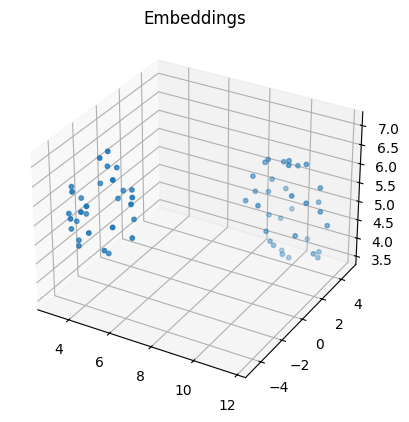

In [96]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(global_embeddings[:, 0], global_embeddings[:, 1], global_embeddings[:, 2], s=10)
ax.set_title('Embeddings')
# plt.axis('off')

In [97]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(global_embeddings[:, 0], global_embeddings[:, 1], global_embeddings[:, 2], s=10, color='gray')
    ax.scatter(query_embeddings[:, 0], query_embeddings[:, 1], query_embeddings[:, 2], s=150, marker='X', color='r')
    ax.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], retrieved_embeddings[:, 2], s=50, facecolors='none', edgecolors='g')
    ax.set_title(f'{query}')
    # plt.axis('off')
    plt.show()

100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


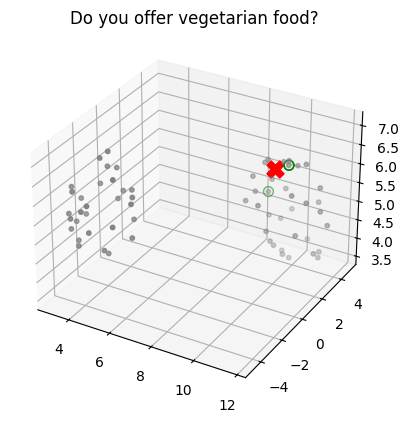

In [98]:
calc_global_embeddings("Do you offer vegetarian food?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


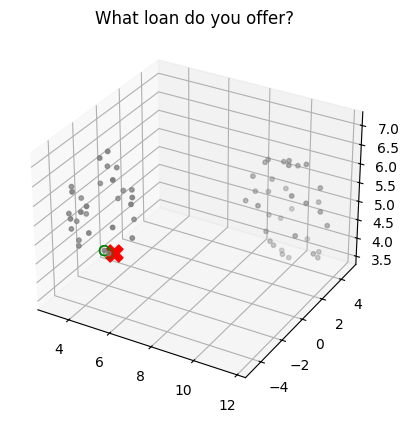

In [99]:
calc_global_embeddings("What loan do you offer?", embeddings, retriever, umap_transformer, umap_embed,
                       global_embeddings)
